In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import pymorphy2

import tensorflow as tf

In [31]:
train = pd.read_csv('train-5.csv')
train.head()

,stars,comment
0,5.0,I taught sections of this book in an undergrad...
1,2.0,This book was required for my undergraduate cl...
2,4.0,Book is really helpful but I cant find equipme...
3,5.0,Enjoyable reading. Recommend to all.
4,5.0,Great book. hard read but great.


In [32]:
test = pd.read_csv('test-2.csv')
test.head()

,comment
0,"A book that will speak to your head, heart, an..."
1,Very Comprehensive and interesting. Exercises ...
2,"People say that this book is difficult, but I ..."
3,Great book for anyone that is maintaining a we...
4,Good information


In [33]:
train.isnull().sum()

stars      0
comment    0
dtype: int64

In [34]:
test.isnull().sum()

comment    0
dtype: int64

In [35]:
plot = train.groupby('stars', as_index=False)\
     .agg({'comment': 'count'})
plot

,stars,comment
0,1.0,1154
1,2.0,715
2,3.0,1151
3,4.0,2295
4,5.0,11202


<AxesSubplot:xlabel='stars', ylabel='comment'>

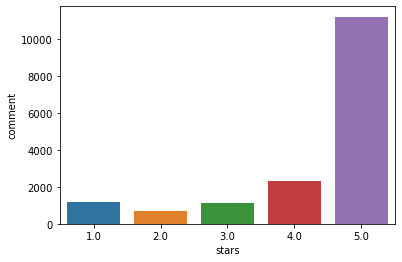

In [36]:
sns.barplot(x='stars', y='comment', data=plot)

In [37]:
train.shape

(16517, 2)

In [38]:
def clean(text):
     text = text.lower()
     text = re.sub(r'\n', '', text)
     return text

In [39]:
train.comment = train.comment.apply(lambda x: clean(x))
test.comment = test.comment.apply(lambda x: clean(x))

In [40]:
ex = nltk.word_tokenize('I taught sections of this book in an undergraduate Ethics of Technology course this year')

In [41]:
train.comment = train.comment.apply(lambda x: nltk.word_tokenize(x))
test.comment = test.comment.apply(lambda x: nltk.word_tokenize(x))

In [42]:
from nltk.corpus import stopwords
def remove_stopwords(text):
     words = [w for w in text if w not in stopwords.words('english')]
     return words

In [43]:
train.comment = train.comment.apply(lambda x: remove_stopwords(x))
test.comment = test.comment.apply(lambda x: remove_stopwords(x))

In [47]:
morph = pymorphy2.MorphAnalyzer()
morph.parse(ex[8])[0].normal_form

'undergraduate'

In [48]:
def lem_word(text):
     return [morph.parse(w)[0].normal_form for w in text]

In [49]:
train.comment = train.comment.apply(lambda x: lem_word(x))
test.comment = test.comment.apply(lambda x: lem_word(x))

In [50]:
def combine_text(list_of_text):
     combine_text = ' '.join(list_of_text)
     return combine_text

In [51]:
train.comment = train.comment.apply(lambda x: combine_text(x))
test.comment = test.comment.apply(lambda x: combine_text(x))

In [56]:
len(train.comment[50])

54

In [55]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
max_nb_words = 40000
max_sequence_len = 300
embedding_dim = 150

tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(train['comment'].values)
word_index = tokenizer.word_index
print(len(word_index))

48370


In [58]:
X = tokenizer.texts_to_sequences(train['comment'].values)
X = pad_sequences(X, maxlen=max_sequence_len)
print(X.shape)

(16517, 300)


In [59]:
y = train.stars
y.shape

(16517,)

In [67]:
model = Sequential()
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 150)          6000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 300, 150)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 300, 150)          180600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 150)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               100400    
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [68]:
epochs = 20
batch_size = 64

history = model.fit(X, y, epochs=epochs, batch_size=batch_size)

Epoch 1/20
259/259 [==============================] - 204s 781ms/step - loss: 3.5143
Epoch 2/20
259/259 [==============================] - 208s 802ms/step - loss: 0.9385
Epoch 3/20
259/259 [==============================] - 220s 850ms/step - loss: 0.6547
Epoch 4/20
259/259 [==============================] - 215s 829ms/step - loss: 0.3996
Epoch 5/20
259/259 [==============================] - 202s 781ms/step - loss: 0.2970
Epoch 6/20
259/259 [==============================] - 202s 780ms/step - loss: 0.2445
Epoch 7/20
259/259 [==============================] - 202s 780ms/step - loss: 0.2411
Epoch 8/20
259/259 [==============================] - 202s 781ms/step - loss: 0.1898
Epoch 9/20
259/259 [==============================] - 202s 780ms/step - loss: 0.1565
Epoch 10/20
259/259 [==============================] - 202s 780ms/step - loss: 0.1356
Epoch 11/20
259/259 [==============================] - 202s 781ms/step - loss: 0.1476
Epoch 12/20
259/259 [==============================] - 202s 780

In [70]:
X_test = tokenizer.texts_to_sequences(test['comment'].values)
X_test = pad_sequences(X_test, maxlen=max_sequence_len)
print(X_test.shape)

(4130, 300)


In [72]:
answer = model.predict(X_test)

In [73]:
sub = pd.DataFrame(answer, columns=['stars'])

In [74]:
sub.head()

,stars
0,4.914809
1,3.987806
2,4.897831
3,4.924437
4,4.485728


In [75]:
sub.to_csv('sub_stars.csv')